In [247]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import textblob
import pandas
import numpy as np
import nltk
from numpy import array
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
import json
from textblob import TextBlob
import ast

%matplotlib inline

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  


In [248]:
label_data = pandas.read_table('ground_truth.txt', dtype=str)#, header=None, names = ["tweetID","label"])
label_data.dtypes
raw_data = pandas.read_table('raw_tweets.txt', dtype=str)#, header=None, names = ["tweetID","text"])
memo_for = pandas.read_table('memos/Memo1.txt',dtype=str, header=None, names = ["memo"])
memo_against = pandas.read_table('memos/Memo2.txt',dtype=str, header=None, names = ["memo"])
memo_neutral = pandas.read_table('memos/Memo4.txt',dtype=str, header=None, names = ["memo"])
raw_data.dtypes

frames = [label_data, raw_data]
#print(label_data['Tweet ID'].intersection(raw_data['Tweet ID']))

data = pandas.merge(label_data,raw_data,on="Tweet ID")
#data = label_data.merge(raw_data, on="Tweet ID")
#a = pandas.Series(list(set(label_data['Tweet ID']) & set(raw_data['Tweet ID'])))
#print(a.shape)

print(len(label_data['Tweet ID'].unique()))
print(len(raw_data['Tweet ID'].unique()))
# for i, row in label_data.iterrows():
#     if ' @ ' in memo_row.memo:
#         data[memo_row.memo] = data.apply(tag_and_sentiment, memo=memo_row.memo, axis=1 )


# print(label_data['Tweet ID'].value_counts())
# print(raw_data['Tweet ID'].value_counts())

data = pandas.concat([label_data, raw_data], axis=1, join='inner',ignore_index=True)
data = data.drop(data.columns[2], axis=1)
data.columns = ['ID','label','text']


#print(d2)
print(data.shape)
#print(memo_for)

395
395
(400, 3)


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Against Abortion,168.0,129.500000,40.108087,34.0,113.75,131.0,140.0,326.0
For Abortion,131.0,136.061069,45.911077,17.0,112.00,136.0,152.0,254.0
Neutral,101.0,140.277228,49.538494,44.0,120.00,136.0,142.0,308.0


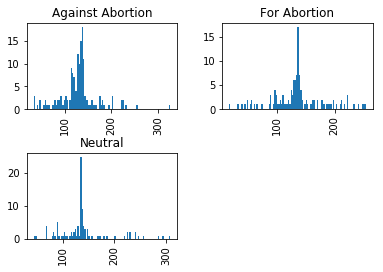

In [249]:
data["length"] = data.apply(lambda row: len(row.text), axis=1)

data.hist(column='length', by='label', bins=100)
data.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Against Abortion,168.0,0.166667,0.485313,0.0,0.0,0.0,0.0,4.0
For Abortion,131.0,0.091603,0.315018,0.0,0.0,0.0,0.0,2.0
Neutral,101.0,0.376238,3.190146,0.0,0.0,0.0,0.0,32.0


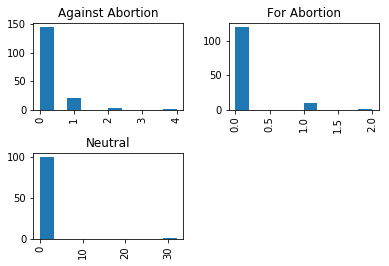

In [250]:
data["exclaim"] = data.apply(lambda row: row.text.count('!'), axis=1)
data.hist(column='exclaim', by='label', bins=10)
data.groupby('label').exclaim.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Against Abortion,168.0,11.738095,14.493541,0.0,5.0,8.0,15.0,113.0
For Abortion,131.0,9.603053,6.768342,0.0,4.0,8.0,14.5,34.0
Neutral,101.0,11.376238,8.865497,1.0,6.0,10.0,14.0,66.0


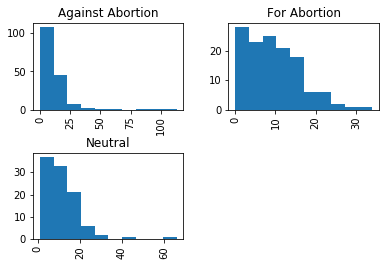

In [251]:
data["capital"] = data.apply(lambda row: sum(1 for c in row.text if c.isupper()), axis=1)
data.hist(column='capital', by='label', bins=10)
data.groupby('label').capital.describe()

In [252]:
def tag_and_sentiment(row,memo):
    blob = TextBlob(row.text)
    memo_spl = memo.split(' @ ')[0]
    memo_emo = memo.split(' @ ')[1]
    if(((blob.sentiment.polarity>=0.5 and memo_emo == 'Positive') or (blob.sentiment.polarity<0.5 and memo_emo == 'Negative')) and memo_spl.lower() in row.text.lower()):
        return 1
    else:
        return 0
    

In [253]:
for i, memo_row in memo_for.iterrows():
    if ' @ ' in memo_row.memo:
        data[memo_row.memo] = data.apply(tag_and_sentiment, memo=memo_row.memo, axis=1 )
    elif ' + ' in memo_row.memo:
        data[memo_row.memo] = data.apply(lambda row: int(memo_row.memo.split(' + ')[0].lower() in row.text.lower() and memo_row.memo.split(' + ')[1].lower() in row.text.lower()), axis=1 )
    else:
        data[memo_row.memo] = data.apply(lambda row: int(memo_row.memo.lower() in row.text.lower()), axis=1 )

#print(data)
#     for j, memo_row in memo_for.iterrows():
        
#     if row['B'] > 1.5:
#         calc_temp   = row['A'] *10
#         calc_temp01 = row['C'] *-10
# data["poundsymb"] = data.apply(lambda row: row.message.count('£'), axis=1)


In [254]:
for i, memo_row in memo_against.iterrows():
    if ' @ ' in memo_row.memo:
        data[memo_row.memo] = data.apply(tag_and_sentiment, memo=memo_row.memo, axis=1 )
    elif ' + ' in memo_row.memo:
        data[memo_row.memo] = data.apply(lambda row: int(memo_row.memo.split(' + ')[0].lower() in row.text.lower() and memo_row.memo.split(' + ')[1].lower() in row.text.lower()), axis=1 )
    else:
        data[memo_row.memo] = data.apply(lambda row: int(memo_row.memo.lower() in row.text.lower()), axis=1 )


In [255]:
class CapitalCountExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def transform(self, df, y=None):
        return np.array([sum(1 for c in row if c.isupper()) for row in df])[:,np.newaxis]

    def fit(self, df, y=None):
        return self


vectorizer = FeatureUnion([
        ('cv', CountVectorizer(stop_words='english',max_features=500)),
        ('capital_count', CapitalCountExtractor())
    ])

In [256]:
vectorizer = CountVectorizer(stop_words='english',max_features=500)
vectorizer = FeatureUnion([
        ('cv', CountVectorizer(stop_words='english',max_features=500)),
        ('capital_count', CapitalCountExtractor())
    ])

train_data = data.sample(frac=0.8, random_state=200)
test_data = data.drop(train_data.index)
#train_data, test_data = train_test_split(data, test_size=0.2)
#print(data.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '])
train_data_bow = vectorizer.fit_transform(train_data['text']).toarray()
print(train_data_bow.shape)

train_data_memos = train_data.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '].values
print(train_data_memos.shape)

train_data_feature_vec = np.concatenate((train_data_bow, train_data_memos), axis=1)
print(train_data_feature_vec.shape)

pca = PCA(n_components=5)
train_data_memos_reduced = pca.fit(train_data_memos)
svm_tweetDetector = svm.SVC(kernel='linear')
lb = preprocessing.LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(train_data["label"])])


(320, 501)
(320, 51)
(320, 552)


In [257]:
scores = model_selection.cross_val_score(svm_tweetDetector, train_data_feature_vec, y_train, scoring ='f1',cv=10)
print('F-1 over 10 folds: ')
f1_scores = pandas.DataFrame(scores)
print(f1_scores)
print('Aggregate F-1 score: ',scores.mean())

scores = model_selection.cross_val_score(svm_tweetDetector, train_data_feature_vec, y_train, scoring ='precision', cv=10)
print('Precision over 10 folds: ')
precision_scores = pandas.DataFrame(scores)
print(precision_scores)
print('Aggregate precision score: ',scores.mean())

scores = model_selection.cross_val_score(svm_tweetDetector, train_data_feature_vec, y_train, scoring ='recall', cv=10)
print('Recall over 10 folds: ')
recall_scores = pandas.DataFrame(scores)
print(recall_scores)
print('Aggregate recall score: ',scores.mean())

scores = model_selection.cross_val_score(svm_tweetDetector, train_data_feature_vec, y_train, scoring ='accuracy', cv=10)
print('Accuracy over 10 folds: ')
accuracy_scores = pandas.DataFrame(scores)
print(accuracy_scores)
print('Aggregate accuracy score: ',scores.mean())

F-1 over 10 folds: 
          0
0  0.714286
1  0.827586
2  0.642857
3  0.692308
4  0.785714
5  0.740741
6  0.571429
7  0.916667
8  0.521739
9  0.727273
Aggregate F-1 score:  0.7140598878604876
Precision over 10 folds: 
          0
0  0.714286
1  0.800000
2  0.600000
3  0.692308
4  0.733333
5  0.714286
6  0.750000
7  1.000000
8  0.600000
9  0.888889
Aggregate precision score:  0.7493101343101343
Recall over 10 folds: 
          0
0  0.714286
1  0.857143
2  0.692308
3  0.692308
4  0.846154
5  0.769231
6  0.461538
7  0.846154
8  0.461538
9  0.615385
Aggregate recall score:  0.6956043956043956
Accuracy over 10 folds: 
          0
0  0.757576
1  0.848485
2  0.687500
3  0.750000
4  0.812500
5  0.781250
6  0.718750
7  0.937500
8  0.645161
9  0.806452
Aggregate accuracy score:  0.7745173509286413


In [258]:
# data.hist(column='length', by='tag', bins=100)
# data.groupby('tag').length.describe()

In [259]:
#data["poundsymb"] =data.apply(lambda row: row.message.count('£'), axis=1)

In [260]:
# data.hist(column='poundsymb', by='tag', bins=10)
# data.groupby('tag').poundsymb.describe()

In [261]:
#for index, row in data.iterrows():
#   row.message = PorterStemmer().stem(row.message)
#print(data)

In [262]:
# train_data = data.sample(frac=0.8, random_state=200)
# test_data = data.drop(train_data.index)


#print(len(train_data))
#print(len(test_data))
#X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(train_data_bow, train_data["tag"], test_size=0.2,random_state=109)

kfold = KFold(n_splits=10, random_state=None, shuffle=True)


#print(kfold.get_n_splits(data))

#train_messages = train_data['message']

#for index, row in train_data.iterrows():
#    row.message = re.sub('[^A-Za-z]', ' ', row.message)

# class CurrencyExtractor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def transform(self, df, y=None):
#         return np.array([row.count('£') for row in df])[:,np.newaxis]

#     def fit(self, df, y=None):
#         return self


#vectorizer = CountVectorizer(stop_words='english',max_features=500)

# vectorizer = FeatureUnion([
#         ('cv', CountVectorizer(stop_words='english',max_features=500)),
#         ('pound_sym', CurrencyExtractor())
#     ])


#train_data_bow.shape

# pipeline_svm = Pipeline([
#     ('bow', vectorizer),
#     ('classifier', svm.SVC(kernel='linear')),
# ])

#train_data_bow.shape

for train_index, test_index in kfold.split(train_data):
    trainData = train_data.iloc[train_index]
    testData = train_data.iloc[test_index]
    #print(len(trainData))
    #print(len(testData))
    train_data_bow = vectorizer.fit_transform(trainData['text']).toarray()
    train_data_memos = trainData.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '].values
    train_data_feature_vec = np.concatenate((train_data_bow, train_data_memos), axis=1)

    svm_tweetDetector = svm.SVC(kernel='linear').fit(train_data_feature_vec, trainData["label"])
    
    test_data_bow = vectorizer.transform(testData['text']).toarray()
    test_data_memos = testData.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '].values
    test_data_feature_vec = np.concatenate((test_data_bow, test_data_memos), axis=1)
    y_pred = svm_tweetDetector.predict(test_data_feature_vec)
    
    #logreg_spamDetector = linear_model.LogisticRegression(n_jobs=1, C=1e5)
    #logreg_spamDetector = logreg_spamDetector.fit(train_data_bow, trainData["tag"])
    #y_pred = logreg_spamDetector.predict(vectorizer.transform(testData['message']).toarray())
    
#     randomForest_spamDetector = RandomForestClassifier(n_jobs=2, random_state=0)
#     randomForest_spamDetector.fit(train_data_bow, trainData["tag"])
#     y_pred = randomForest_spamDetector.predict(vectorizer.transform(testData['message']).toarray())
    
#     accuracy = accuracy_score(testData["label"],y_pred)
#     print('Accuracy: ', accuracy)
#     precision = precision_score(testData["label"],y_pred,average=None)
#     print('Precision: ', precision)
#     recall = recall_score(testData["label"],y_pred,average=None)
#     print('Recall: ', recall)
#     f1 = f1_score(testData["label"],y_pred,average=None)
#     print('F1:',f1, '\n')

#train_data_feature_vec = vectorizer.fit_transform(train_data['text']).toarray()


# # logreg_spamDetector = linear_model.LogisticRegression(n_jobs=1, C=1e5)
# # logreg_spamDetector = logreg_spamDetector.fit(train_data_bow, train_data["tag"])
# # scores = model_selection.cross_val_score(logreg_spamDetector, train_data_bow, train_data["tag"], cv=5)
# # print(scores)


# svm_spamDetector = svm.SVC(kernel='linear')
# lb = preprocessing.LabelBinarizer()

# y_train = np.array([number[0] for number in lb.fit_transform(train_data["tag"])])

train_data_bow = vectorizer.fit_transform(train_data['text']).toarray()
train_data_memos = train_data.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '].values
train_data_feature_vec = np.concatenate((train_data_bow, train_data_memos), axis=1)

test_data_bow = vectorizer.transform(test_data['text']).toarray()
test_data_memos = test_data.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '].values
test_data_feature_vec = np.concatenate((test_data_bow, test_data_memos), axis=1)

print('SVM')
print("Test set metrics")
svm_tweetDetector = svm.SVC(kernel='linear').fit(train_data_feature_vec, train_data["label"])
y_pred = svm_tweetDetector.predict(test_data_feature_vec)

accuracy = accuracy_score(test_data["label"],y_pred)
print('Accuracy: ', accuracy)
precision = precision_score(test_data["label"],y_pred,average=None)
print('Precision: ', precision)
recall = recall_score(test_data["label"],y_pred,average=None)
print('Recall: ', recall)
f1 = f1_score(test_data["label"],y_pred,average=None)
print('F1:',f1, '\n')

# scores = model_selection.cross_val_score(svm_spamDetector, train_data_bow, y_train, scoring ='f1',cv=5)
# print('F-1 over 5 folds: ')
# f1_scores = pandas.DataFrame(scores)
# print(f1_scores)
# print('Aggregate F-1 score: ',scores.mean())

# scores = model_selection.cross_val_score(svm_spamDetector, train_data_bow, y_train, scoring ='precision', cv=5)
# print('Precision over 5 folds: ')
# precision_scores = pandas.DataFrame(scores)
# print(precision_scores)
# print('Aggregate precision score: ',scores.mean())

# scores = model_selection.cross_val_score(svm_spamDetector, train_data_bow, y_train, scoring ='recall', cv=5)
# print('Recall over 5 folds: ')
# recall_scores = pandas.DataFrame(scores)
# print(recall_scores)
# print('Aggregate recall score: ',scores.mean())

# scores = model_selection.cross_val_score(svm_spamDetector, train_data_bow, y_train, scoring ='accuracy', cv=5)
# print('Accuracy over 5 folds: ')
# accuracy_scores = pandas.DataFrame(scores)
# print(accuracy_scores)
# print('Aggregate accuracy score: ',scores.mean())


# print('Random forest classifier')
# print("Test set metrics")
# randomForest_spamDetector = RandomForestClassifier(n_jobs=2, random_state=0)
# randomForest_spamDetector.fit(train_data_bow, train_data["tag"])
# y_pred = randomForest_spamDetector.predict(vectorizer.transform(test_data['message']).toarray())

# accuracy = accuracy_score(test_data["tag"],y_pred)
# print('Accuracy: ', accuracy)
# precision = precision_score(test_data["tag"],y_pred,average=None)
# print('Precision: ', precision)
# recall = recall_score(test_data["tag"],y_pred,average=None)
# print('Recall: ', recall)
# f1 = f1_score(test_data["tag"],y_pred,average=None)
# print('F1:',f1, '\n')



# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, y_train, scoring ='f1',cv=5)
# print('F-1 over 5 folds: ')
# f1_scores = pandas.DataFrame(scores)
# print(f1_scores)
# print('Aggregate F-1 score: ',scores.mean())

# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, y_train, scoring ='precision', cv=5)
# print('Precision over 5 folds: ')
# precision_scores = pandas.DataFrame(scores)
# print(precision_scores)
# print('Aggregate precision score: ',scores.mean())

# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, y_train, scoring ='recall', cv=5)
# print('Recall over 5 folds: ')
# recall_scores = pandas.DataFrame(scores)
# print(recall_scores)
# print('Aggregate recall score: ',scores.mean())

# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, y_train, scoring ='accuracy', cv=5)
# print('Accuracy over 5 folds: ')
# accuracy_scores = pandas.DataFrame(scores)
# print(accuracy_scores)
# print('Aggregate accuracy score: ',scores.mean())

# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, train_data["tag"], cv=5)
# print(scores)


#    classifier = nltk.NaiveBayesClassifier.train(train_data)
#    sum += nltk.classify.accuracy(classifier, test_data)
#average = sum/3


#train_data_bow.shape

#print(train_data_bow)
#print(vectorizer.get_feature_names())

#word_count_bag = CountVectorizer.fit_transform(corpus)
#print(word_count_bag.toarray())
#print(vectorizer.get_feature_names())
#word_count_bag.shape

#print(train_data["tag"])

#svm_spamDetector = svm.SVC(kernel='linear').fit(train_data_bow, train_data["tag"])

#test = vectorizer.transform(["Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16"]).toarray()
#test.shape
#svm_spamDetector.predict(vectorizer.transform(["Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16"]).toarray())[0]

SVM
Test set metrics
Accuracy:  0.675
Precision:  [0.72727273 0.73333333 0.52380952]
Recall:  [0.88888889 0.47826087 0.52380952]
F1: [0.8        0.57894737 0.52380952] 

